In [1]:
import pandas as pd

# Step 1: Read TSV file
tcga = pd.read_csv("Data_for_tcga_graph/tcga_data_summary.tsv", sep='\t')

# Step 2: Convert 'disease' column to categorical with specific levels
tcga['disease'] = pd.Categorical(tcga['disease'], categories=["Bladder", "Prostate", "RCC"], ordered=True)

# Step 3: Reverse the 'bin' column and convert to categorical
tcga['bin'] = pd.Categorical(tcga['bin'][::-1])

display(tcga.head())

,chr,bin,arm,pos,value,disease,change
0,chr1,chr1:5000000-10000000,1p,7500000.0,-0.075269,Bladder,Loss
1,chr1,chr1:5000000-10000000,1p,7500000.0,0.096774,Bladder,Gain
2,chr1,chr1:5000000-10000000,1p,7500000.0,-0.068966,RCC,Loss
3,chr1,chr1:5000000-10000000,1p,7500000.0,0.000000,RCC,Gain
4,chr1,chr1:5000000-10000000,1p,7500000.0,-0.036364,Prostate,Loss


In [2]:
# Read the TSV file and drop the specified columns
# Read the TSV file
libraries = pd.read_csv("Data_for_tcga_graph/libraries.tsv", sep='\t')

# Drop specific columns
libraries = libraries.drop(columns=['file', 'library_type', 'isolation_type'])


display(libraries.head())

,library,cohort,serial,duplicate,batch,split
0,58,Healthy,0,0,2,testing
1,73,Healthy,0,0,2,training
2,74,Healthy,0,0,2,testing
3,81,Healthy,0,0,2,testing
4,83,Healthy,0,0,2,training


In [3]:
arm_z = pd.read_csv("Data_for_tcga_graph/arm_z.tsv", sep='\t')

display(arm_z.head())


,library,chr,arm,count,total,prop,z
0,58,chr1,p,2412932,34635949,0.069666,0.500638
1,58,chr1,q,1736831,34635949,0.050145,0.481548
2,58,chr10,p,689142,34635949,0.019897,-0.410989
3,58,chr10,q,1803527,34635949,0.052071,0.848811
4,58,chr11,p,777706,34635949,0.022454,-0.218577


In [4]:


# Right join with libraries on 'library'
arm_z_wide = arm_z.merge(libraries, on="library", how="right")

# Apply filtering conditions
arm_z_wide = arm_z_wide[
    (arm_z_wide['serial'] == 0) | ((arm_z_wide['serial'] == 1) & (arm_z_wide['cohort'] == "RCC"))
]
arm_z_wide = arm_z_wide[
    (arm_z_wide['duplicate'] == 0) | ((arm_z_wide['duplicate'] == 1) & (arm_z_wide['batch'] != 1))
]

# Preserve 'cohort' before pivoting
cohort_values = arm_z_wide[['library', 'cohort']].drop_duplicates()

# Drop unnecessary columns before pivoting
columns_to_drop = ['count', 'total', 'prop', 'serial', 'duplicate', 'batch', 'split']
columns_to_drop = [col for col in columns_to_drop if col in arm_z_wide.columns]  # Drop only existing columns
arm_z_wide = arm_z_wide.drop(columns=columns_to_drop)

# Pivot wider using 'chr' and 'arm' as new column names, with 'z' as values
arm_z_wide = arm_z_wide.pivot(index="library", columns=["chr", "arm"], values="z")

# Flatten column names (convert MultiIndex to single-level with format 'chr_arm')
arm_z_wide.columns = ['{}_{}'.format(c[0], c[1]) for c in arm_z_wide.columns]

# Reset index to bring 'library' back as a column
arm_z_wide = arm_z_wide.reset_index()

# Reattach 'cohort' to maintain category levels
arm_z_wide = arm_z_wide.merge(cohort_values, on="library", how="left")

# Convert 'cohort' to categorical
arm_z_wide['cohort'] = pd.Categorical(arm_z_wide['cohort'], categories=["Healthy", "Bladder", "Prostate", "RCC"], ordered=True)

# Set 'library' as the index
arm_z_wide = arm_z_wide.set_index("library")

# Display the output
display(arm_z_wide.head())


,chr1_p,chr1_q,chr10_p,chr10_q,chr11_p,chr11_q,chr12_p,chr12_q,chr13_q,chr14_q,...,chr5_q,chr6_p,chr6_q,chr7_p,chr7_q,chr8_p,chr8_q,chr9_p,chr9_q,cohort
library,,,,,,,,,,,,,,,,,,,,,
58,0.500638,0.481548,-0.410989,0.848811,-0.218577,0.824577,0.649369,-0.405411,0.029293,0.490795,...,-0.191412,0.609609,-0.420965,-0.786807,-0.330025,-0.402745,-0.713632,-0.284287,0.108390,Healthy
73,-1.083426,-1.220784,0.459364,0.366229,1.666293,-0.584459,0.152188,-0.704706,0.642475,-0.817676,...,-0.756864,-1.000383,1.054155,0.408653,1.292797,0.072355,0.748582,0.807086,0.277831,Healthy
74,-0.420803,0.051099,1.188064,-0.764085,-0.576497,-2.138650,-0.094162,-0.353201,0.220072,-0.075865,...,0.630959,0.631229,0.197558,0.130784,-0.146538,-0.379365,0.138085,0.162191,-0.578078,Healthy
81,-1.398996,1.308646,-0.794303,0.732416,3.011589,1.921797,-1.770148,-0.809331,0.325861,-2.382215,...,-0.189816,-2.545631,1.817232,1.264974,2.246687,1.569387,1.580092,0.393157,0.338279,Healthy
83,-0.033880,0.633287,-0.678556,0.435361,0.383254,0.720053,0.868606,-0.358796,0.112183,0.373611,...,2.086188,0.603034,0.294714,0.672683,0.055100,-1.005939,0.745358,0.468220,-0.347326,Healthy


In [5]:
# Convert from wide format to long format (correcting the mistake)
arm_z_long = arm_z_wide.melt(
    id_vars=["cohort"],   # Keep 'cohort' as an identifier
    var_name="arm",       # New column for chromosome-arm names
    value_name="z"        # Values from the wide table
)

# Display the result
display(arm_z_long.head())




,cohort,arm,z
0,Healthy,chr1_p,0.500638
1,Healthy,chr1_p,-1.083426
2,Healthy,chr1_p,-0.420803
3,Healthy,chr1_p,-1.398996
4,Healthy,chr1_p,-0.033880


In [6]:
# Define the chromosome order as a list
chromosome_order = [
    'chr1_p', 'chr1_q', 'chr2_p', 'chr2_q', 'chr3_p', 'chr3_q',
    'chr4_p', 'chr4_q', 'chr5_p', 'chr5_q', 'chr6_p', 'chr6_q',
    'chr7_p', 'chr7_q', 'chr8_p', 'chr8_q', 'chr9_p', 'chr9_q',
    'chr10_p', 'chr10_q', 'chr11_p', 'chr11_q', 'chr12_p', 'chr12_q',
    'chr13_q', 'chr14_q', 'chr15_q', 'chr16_p', 'chr16_q', 'chr17_p',
    'chr17_q', 'chr18_p', 'chr18_q', 'chr19_p', 'chr19_q', 'chr20_p',
    'chr20_q', 'chr21_q', 'chr22_q'
]


In [7]:
# Define the labels as a list
labels = [
    '1p', '1q', '2p', '2q', '3p', '3q', '4p', '4q', '5p', '5q', '6p', '6q',
    '7p', '7q', '8p', '8q', '9p', '9q', '10p', '10q', '11p', '11q',
    '12p', '12q', '13q', '14q', '15q', '16p', '16q', '17p', '17q',
    '18p', '18q', '19p', '19q', '20p', '20q', '21q', '22q'
]


In [8]:
# Reverse chromosome order and labels
chromosome_order_rev = list(reversed(chromosome_order))
labels_rev = list(reversed(labels))

# Convert 'arm' to categorical with reversed chromosome order
arm_z_long['arm'] = pd.Categorical(
    arm_z_long['arm'],
    categories=chromosome_order_rev,  # Reverse order
    ordered=True
)

# Replace categorical levels with new labels
rename_dict = dict(zip(chromosome_order_rev, labels_rev))
arm_z_long['arm'] = arm_z_long['arm'].map(rename_dict)

# Display the result
display(arm_z_long.head())


,cohort,arm,z
0,Healthy,1p,0.500638
1,Healthy,1p,-1.083426
2,Healthy,1p,-0.420803
3,Healthy,1p,-1.398996
4,Healthy,1p,-0.033880


In [9]:
# Convert 'cohort' to categorical with specific levels
arm_z_long['cohort'] = pd.Categorical(
    arm_z_long['cohort'], 
    categories=["Healthy", "Bladder", "Prostate", "RCC"], 
    ordered=True
)

# Display the result
display(arm_z_long.head())


,cohort,arm,z
0,Healthy,1p,0.500638
1,Healthy,1p,-1.083426
2,Healthy,1p,-0.420803
3,Healthy,1p,-1.398996
4,Healthy,1p,-0.033880


<Figure size 800x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

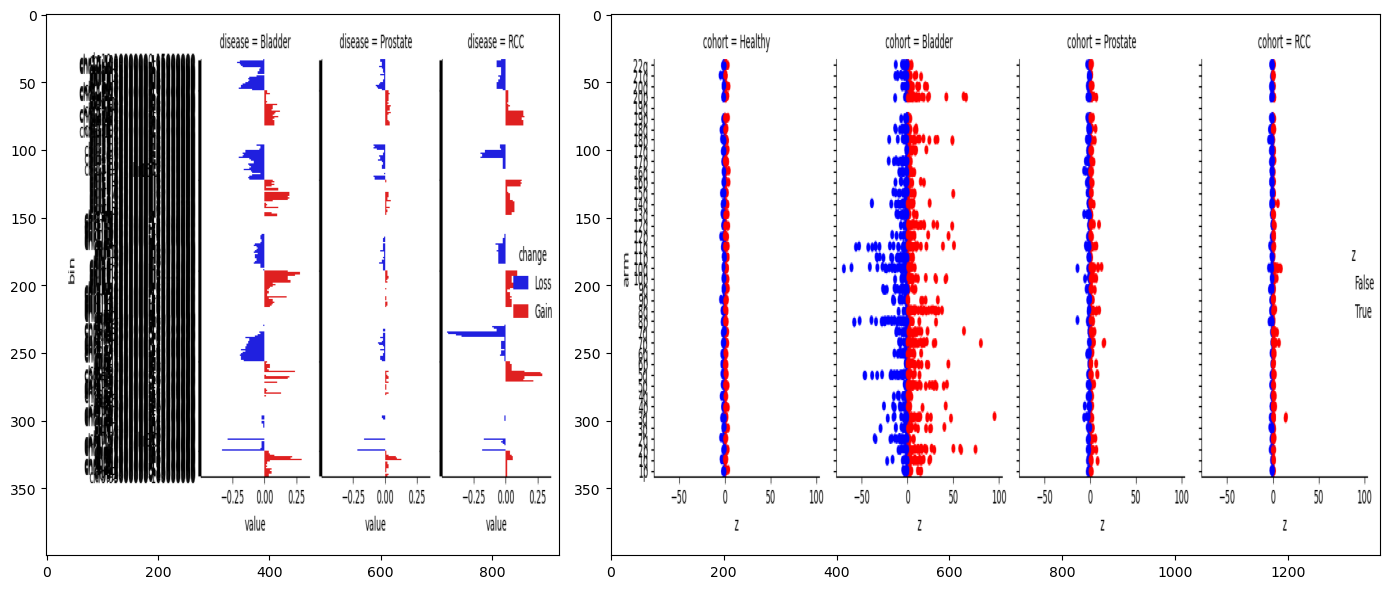

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define disease labels (labeller equivalent)
disease_labels = {
    "Bladder": "BLCA\nn = 93",
    "Prostate": "PRAD\nn = 110",
    "RCC": "KIRC\nn = 87"
}

# Define cohort labels (labeller equivalent)
cohort_labels = {
    "Healthy": "Healthy\nn = 36",
    "Bladder": "Bladder\nn = 94",
    "Prostate": "Prostate\nn = 42",
    "RCC": "RCC\nn = 34"
}

# 🔹 First Plot: TCGA Data (Bar Chart)
plt.figure(figsize=(8, 6))
tcga_plot = sns.catplot(
    data=tcga,
    x="value",
    y="bin",
    hue="change",
    col="disease",
    col_order=["Bladder", "Prostate", "RCC"],
    kind="bar",
    height=4,
    aspect=0.7,
    palette={"Gain": "red", "Loss": "blue"}
)

# Modify facet labels
for ax, disease in zip(tcga_plot.axes.flat, disease_labels.keys()):
    ax.set_title(disease_labels[disease], fontsize=10)

tcga_plot.set_axis_labels("", "Chromosome Arm")
tcga_plot.set_titles(col_template="{col_name}")
tcga_plot.set(yticks=[])
tcga_plot.despine(left=True)

# 🔹 Second Plot: Urine cfDNA Chromosome Arm Z-Scores (Scatter Plot)
plt.figure(figsize=(10, 6))
arm_z_plot = sns.catplot(
    data=arm_z_long,
    x="z",
    y="arm",
    hue=(arm_z_long["z"] > 0),  # Color based on positive/negative Z-score
    hue_order=[False, True],  # False (blue), True (red)
    col="cohort",
    col_order=["Healthy", "Bladder", "Prostate", "RCC"],
    kind="strip",
    height=4,
    aspect=0.8,
    palette={False: "blue", True: "red"}
)

# Modify facet labels
for ax, cohort in zip(arm_z_plot.axes.flat, cohort_labels.keys()):
    ax.set_title(cohort_labels[cohort], fontsize=10)

arm_z_plot.set_axis_labels("Z-Score", "Chromosome Arm")
arm_z_plot.set_titles(col_template="{col_name}")
arm_z_plot.despine(left=True)

# 🔹 Combine both plots
fig, axes = plt.subplots(1, 2, figsize=(14, 6), gridspec_kw={'width_ratios': [1, 1.5]})

# Move Seaborn plots into combined figure
for i, g in enumerate([tcga_plot, arm_z_plot]):
    for ax in g.axes.flat:
        axes[i].imshow(ax.figure.canvas.buffer_rgba(), aspect="auto")
    plt.close(g.figure)

plt.tight_layout()
plt.show()
